<a href="https://colab.research.google.com/github/rbondili/Ecommerce_E2E_MLProject/blob/master/04_Data_Pipeline_for_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4) Customer categories

In [ ]:
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/drive')
relative_path = '/content/drive/My Drive/Colab Notebooks/Customer Segmentation/ecommerce-data/'
df_cleaned = pd.read_csv(relative_path + 'data_cleaned.csv', encoding='latin', dtype={'CustomerID': str}) 
X = pd.read_csv(relative_path + 'Matrix_X.csv') 

unique_products = df_cleaned['Description'].unique()
clusters_tmp = pd.read_csv(relative_path + 'Matrix_X_clusters.csv') 
clusters = clusters_tmp.to_numpy()[:,1]

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 4.1) New feature

Add new feature: `categ_product` into `df_cleaned` dataframe. Use information, obtained in previous part: `clusters` and `unique_procudts`.

In [ ]:
print(unique_products.shape)
print(clusters.shape)
df_cleaned = df_cleaned.iloc[:, range(2,12)]
corresp = dict()
for key, val in zip(unique_products, clusters):
    corresp[key] = val 
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)
df_cleaned.head(5)

(3878,)
(3878,)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice,categ_product
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,15.30,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,22.00,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,20.34,2


## 4.2) Money spend for categories
Add 5 new features with names `categ_0` to `categ_4` to `df_cleaned` dataset, which indicate the money spent on each product category.

In [ ]:
# add 5 variables - the money spent on each of the 5 categories
for i in range(5):
    col = 'categ_{}'.format(i)        
    #fill new columns here
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['TotalPrice']
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,0,15.3,0.0,0.00,0.0,0.0
1,536365,WHITE METAL LANTERN,2,0.0,0.0,20.34,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,2,0.0,0.0,22.00,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,2,0.0,0.0,20.34,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,2,0.0,0.0,20.34,0.0,0.0


## 4.3) Basket price with categories

We then create a dataframe where each row is a purchase (unique `InvoiceNo`) with total amount of money, and the amount spent on each product category. The features we have here are the following:
`CustomerID`, `InvoiceNo`, `Basket Price`, `categ_0` to `categ_4` and `InvoiceDate`


In [ ]:
# sum the commands for each order
categ_col = ['categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
basket_price = df_cleaned.groupby(['CustomerID', 'InvoiceDate', 'InvoiceNo'])[categ_col].sum().reset_index()
basket_price['BasketPrice'] = basket_price[categ_col].sum(axis=1)
basket_price = basket_price[basket_price['BasketPrice'] > 0]
basket_price.head()
basket_price.shape

(18562, 9)

In [ ]:
# percentage of the price of the order / product category
for i in range(5):
    col = 'categ_{}'.format(i) 
    #for each category put the sum of all products with this category

basket_price.head() 

,CustomerID,InvoiceDate,InvoiceNo,categ_0,categ_1,categ_2,categ_3,categ_4,BasketPrice
0,12346.0,2011-01-18 10:01:00,541431,0.00,0.00,0.00,77183.6,0.00,77183.60
1,12347.0,2010-12-07 14:57:00,537626,83.40,124.44,293.35,187.2,23.40,711.79
2,12347.0,2011-01-26 14:30:00,542237,53.10,38.25,169.20,130.5,84.34,475.39
3,12347.0,2011-04-07 10:43:00,549222,71.10,38.25,115.00,330.9,81.00,636.25
4,12347.0,2011-06-09 13:01:00,556201,78.06,19.90,168.76,74.4,41.40,382.52


## 4.4) Customer data

We create a dataframe where each row correspond to a customer. The columns are CustomerID, number of transactions, min, max, mean, sum of spent money, and percentage of money for each category.
Call this new dataframe `transactions_per_user`.

In [ ]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['BasketPrice'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12346.0,1,77183.60,77183.60,77183.600000,77183.60,0.000000,0.000000,0.000000,100.000000,0.000000
1,12347.0,7,224.82,1294.32,615.714286,4310.00,20.805104,12.041531,29.540371,26.375870,11.237123
2,12348.0,4,227.44,892.80,449.310000,1797.24,0.000000,20.030714,0.000000,41.953217,38.016069
3,12349.0,1,1757.55,1757.55,1757.550000,1757.55,12.245455,46.021450,10.713778,26.506216,4.513101
4,12350.0,1,334.40,334.40,334.400000,334.40,27.900718,11.961722,0.000000,48.444976,11.692584


Let's find the number and the percentage of customers who purchased only once.

In [ ]:
# to finish
cust_pct_1prod = (transactions_per_user[transactions_per_user['count'] == 1]).shape[0] / transactions_per_user.shape[0] * 100
print(f'Percentage of customers who purchased only once {round(cust_pct_1prod, 2)} %')

Percentage of customers who purchased only once 34.37 %


## 4.5) Creation of customers categories
Choose features: `count`,`min`,`max`,`mean`,`categ_0`,`categ_1`,`categ_2`,`categ_3`,`categ_4` and create new matrix `matrix_customers`. Use standard scaler and call the result as `scaled_matrix_customers`.

In [ ]:
from sklearn.preprocessing import StandardScaler

selected_customers = transactions_per_user.copy(deep = True)

matrix_customers = (transactions_per_user.iloc[:,range(1,11)]).values

scaler = StandardScaler()
scaled_matrix_customers = scaler.fit_transform(matrix_customers)
scaled_matrix_customers.shape


(4338, 10)

## 4.6) K-Means again - for customers
Using scaled_matrix with numbers of clusters from 3 to 14 included. Compute the silhouetter score for each number. Print number of clients in each category.

For n_clusters = 3 The average silhouette_score is : 0.18209156571059015
For n_clusters = 4 The average silhouette_score is : 0.1820871488319779
For n_clusters = 5 The average silhouette_score is : 0.1878378852944818
For n_clusters = 6 The average silhouette_score is : 0.17865258492784203
For n_clusters = 7 The average silhouette_score is : 0.19227056732180264
For n_clusters = 8 The average silhouette_score is : 0.2090556070965617
For n_clusters = 9 The average silhouette_score is : 0.23651920829468687
For n_clusters = 10 The average silhouette_score is : 0.2407720005132987
For n_clusters = 11 The average silhouette_score is : 0.24499124143680862
For n_clusters = 12 The average silhouette_score is : 0.2034612932319751
For n_clusters = 13 The average silhouette_score is : 0.20604730662871687
For n_clusters = 14 The average silhouette_score is : 0.2101602381139599


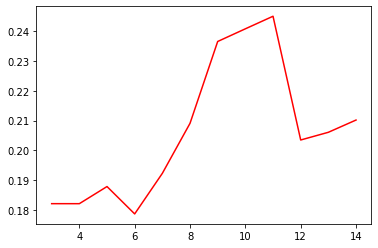

In [ ]:
# Try some numbers of clusters from 3 to 14 and choose the best number of clusters.
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

scaled_matrix = scaled_matrix_customers
Silhouettes = []
N=[]
for n_clusters in range(3,15):
    N.append(n_clusters)
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters)
    Silhouettes.append(silhouette_avg)

    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

plt.plot(N, Silhouettes, c='r')

In [ ]:
# n_clusters = ??
#As we did previously, try to run several times, until you get good result
silhouette_avg = -1
n_clusters = 12
while silhouette_avg < 0.201:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

pd.Series(clusters).value_counts()

For n_clusters = 12 The average silhouette_score is : 0.20397129241722642


11    1436
8     1137
6      396
4      318
2      311
3      310
9      290
0      125
10       8
7        5
5        1
1        1
dtype: int64

In [ ]:
# nb of customers per cluster
cluster_clients = pd.Series(clusters)

## 4.7) Customers morphotype

In this section, we compute the statistics for each group of customers and visulize them. Create new `merged_df` dataset with the same features as `transactions_per_user` dataframe, but with `n_clusters` rows: for each cluster - use mean of values. So you should have dataframe with sizes `n_cluster` $\times$ 12.

In [ ]:
# Customer clusters
selected_customers.loc[:, 'cluster'] = clusters

merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])

#merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

merged_df

number of customers: 4338


,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size,CustomerID
cluster,,,,,,,,,,,,
9.0,2.341379,220.505828,369.249897,279.809165,680.972069,11.145703,8.278246,6.406467,19.225688,54.943896,290,NaN
6.0,2.512626,217.835076,349.924394,278.538382,697.751013,11.716045,8.976581,6.955010,61.474780,10.877584,396,NaN
3.0,2.674194,284.563452,443.104871,351.147214,939.234323,7.071162,74.072894,7.837859,7.637666,3.380420,310,NaN
4.0,2.735849,249.106918,443.733050,335.474373,1044.736604,13.627732,12.371551,53.589832,13.673005,6.737879,318,NaN
2.0,3.025723,242.829486,459.076238,342.665409,1049.792444,63.705627,8.789553,7.757378,13.143982,6.603461,311,NaN
8.0,3.565523,259.014452,558.816229,391.042287,1340.902430,18.987977,34.362439,18.712666,19.290469,8.646449,1137,NaN
11.0,4.026462,247.155850,552.723391,383.525835,1508.338134,23.589781,13.009547,16.401976,30.285058,16.713638,1436,NaN
0.0,25.488000,125.797200,2842.286640,919.787120,16881.063120,26.806320,22.976785,16.711402,22.743318,10.762174,125,NaN
10.0,121.000000,20.651250,2988.347500,501.034793,55099.491250,24.501065,23.918127,15.072485,24.570151,11.938171,8,NaN


## 4.8) Data visualisation

In [ ]:
# function to plot
import matplotlib.pyplot as plt

def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

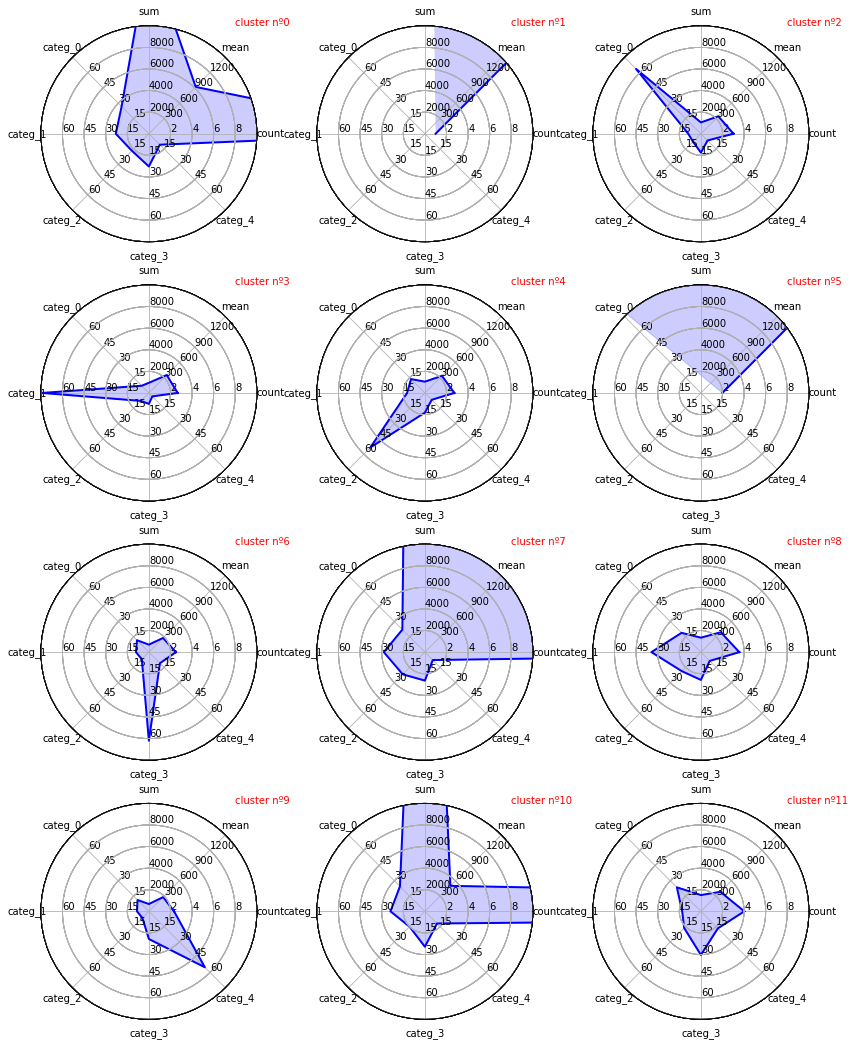

In [ ]:
# display
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    
    #
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

## 4.9) Save data selected_customers data to the file `data_selected_customers.csv`

In [ ]:
selected_customers.to_csv(relative_path + 'data_selected_customers.csv')